License: LGPLv3

# ChIP-Seq and RNA-Seq Integration

## Linking RNA-Seq results with ChIP-Seq results

Now that we have gone over the basics of RNA-Seq and ChIP-Seq, we will try to "integrate" the two datasets. 
To do this, I first intersected the Ab1 and RNAPII peaks to get the overlapping ones which I will use for this
analysis. There are several ways to do this, but I chose to use `bedtools intersect`. We can go ahead and read in
the peaks using the same method as before:

In [1]:
# Load the libraries
# These will need to be installed already
suppressMessages(require(ChIPseeker))
suppressMessages(require(TxDb.Hsapiens.UCSC.hg38.knownGene))
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

# Load in the overlapping peaks
idir <- "/home/ubuntu/data/chipseq/fullset"
chip.peaks <- readPeakFile(file.path(idir, "peaks", "Ab1_RNAPII.overlapped.filtered.intersected.narrowPeak"), 
                           header=FALSE)

# Peek at the data
head(chip.peaks)

GRanges object with 6 ranges and 7 metadata columns:
      seqnames             ranges strand |                  V4        V5
         <Rle>          <IRanges>  <Rle> |            <factor> <integer>
  [1]    chr10 [1489238, 1489661]      * | Ab1.input_peak_2215        51
  [2]    chr10 [3172410, 3172896]      * | Ab1.input_peak_2231       109
  [3]    chr10 [5665920, 5666392]      * | Ab1.input_peak_2242       324
  [4]    chr10 [5684424, 5684866]      * | Ab1.input_peak_2243       593
  [5]    chr10 [5775761, 5776080]      * | Ab1.input_peak_2245       125
  [6]    chr10 [5977538, 5978102]      * | Ab1.input_peak_2251        92
            V6        V7        V8        V9       V10
      <factor> <numeric> <numeric> <numeric> <integer>
  [1]        .   4.06589   7.85770   5.11926       275
  [2]        .   5.36279  14.11020  10.98270       354
  [3]        .  12.79724  36.38798  32.48447       313
  [4]        .  19.03980  63.71320  59.39371       222
  [5]        .   5.73264  15.7948

Next, I will annotate the peaks. To save time, I have already done this, and we can simply load the Rdataset:

In [2]:
## Annotate
# peakAnno <- annotatePeak(chip.peaks, TxDb=txdb, 
#                          tssRegion=c(-3000,3000),
#                          annoDb="org.Hs.eg.db", verbose=FALSE)

# We will simply load the pre-existing Robject
load(file.path(idir, "peaks", "Rdata", "Ab1_RNAPII.overlapped.annotated.Rdata"))

# Peek at first few rows
head(as.data.frame(peakAnno))

seqnames,start,end,width,strand,V4,V5,V6,V7,V8,⋯,geneStart,geneEnd,geneLength,geneStrand,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME
chr10,1489238,1489661,424,*,Ab1.input_peak_2215,51,.,4.06589,7.85770,⋯,1526630,1556984,30355,1,642394,uc001ign.3,-36969,ENSG00000205696,ADARB2-AS1,ADARB2 antisense RNA 1
chr10,3172410,3172896,487,*,Ab1.input_peak_2231,109,.,5.36279,14.11020,⋯,3136924,3172841,35918,2,10531,uc001igr.2,0,ENSG00000107959,PITRM1,pitrilysin metallopeptidase 1
chr10,5665920,5666392,473,*,Ab1.input_peak_2242,324,.,12.79724,36.38798,⋯,5638857,5666595,27739,2,79754,uc001iig.2,203,ENSG00000196372,ASB13,ankyrin repeat and SOCS box containing 13
chr10,5684424,5684866,443,*,Ab1.input_peak_2243,593,.,19.03980,63.71320,⋯,5684838,5763740,78903,1,54906,uc001iij.3,0,ENSG00000108021,FAM208B,family with sequence similarity 208 member B
chr10,5775761,5776080,320,*,Ab1.input_peak_2245,125,.,5.73264,15.79484,⋯,5765223,5813549,48327,2,2665,uc001iil.4,37469,ENSG00000057608,GDI2,GDP dissociation inhibitor 2
chr10,5977538,5978102,565,*,Ab1.input_peak_2251,92,.,6.88479,12.31191,⋯,5943894,5977611,33718,2,3601,uc031vvx.1,0,ENSG00000134470,IL15RA,interleukin 15 receptor subunit alpha


Now, we will subset to peaks within a particular distance from the TSS using the `distanceToTSS` column.
I have chosen an arbitrary distance of 30,000 bp; however, this value will depend on the known biology of your 
factor or your own stringency. I can subset the data.frame using the built-in `subset()` function:

In [3]:
## Subset peaks by the absolute value of distanceToTSS
## We arbitrarily chose 30,000 bp as the cutoff. We also
## need to remove peaks where there is no known official gene symbol.
## We can do this using the is.na() function
peakAnno.30kb <- subset(as.data.frame(peakAnno), abs(distanceToTSS) < 30000 & !is.na(SYMBOL))

## Next, let's create a vector of unique gene symbols
genes.chip <- unique(peakAnno.30kb$SYMBOL)
print("The number of unique genes:")
length(genes.chip)

[1] "The number of unique genes:"


[1] 4565

Now that we have our ChIP-Seq genes, we need to load in the RNA-Seq data.

In [4]:
## Load in the RNA-Seq data you output earlier
rnaseq.dat <- read.delim(file.path(idir, "rnaseq", "DLBC.coding.KOvsWT.deseq2.txt.flt.fdr0.05_fc1.5"),
                        header=TRUE, stringsAsFactors=FALSE)

## Peek at data
head(rnaseq.dat)

ENSEMBL,SYMBOL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,foldChange
ENSG00000006282.20,SPATA20,339.18678,-0.6136447,0.11428784,-5.369291,7.904659e-08,4.426258e-06,-1.530120
ENSG00000007944.14,MYLIP,498.97981,-0.8256700,0.10832360,-7.622254,2.492846e-14,6.409666e-12,-1.772358
ENSG00000019549.8,SNAI2,143.41913,0.6023509,0.15267109,3.945416,7.966161e-05,1.475966e-03,1.518188
ENSG00000026025.13,VIM,101.16900,-0.7806354,0.16508484,-4.728692,2.259707e-06,7.864655e-05,-1.717887
ENSG00000035403.16,VCL,853.07441,-1.0732866,0.09343159,-11.487407,1.526253e-30,2.403657e-27,-2.104222
ENSG00000036828.13,CASR,43.93388,0.6640367,0.18040775,3.680755,2.325442e-04,3.551303e-03,1.584510


Next, we will subset our RNA-Seq data to the genes found in the ChIP-Seq dataset using the `subset()` command again:

In [5]:
## Select rows from RNA-Seq data that contain genes in the
## ChIP-Seq dataset
shared.dat <- subset(rnaseq.dat, SYMBOL %in% genes.chip)

print("There are this many overlapping genes:")
dim(shared.dat)[1]

print("These are the overlapping genes:")
shared.dat$SYMBOL

[1] "There are this many overlapping genes:"


[1] 58

[1] "These are the overlapping genes:"


[1] "MYLIP"     "SNAI2"     "SREBF1"    "LRRC16A"   "DDX43"     "STRADB"   
 [7] "FAM234B"   "CYP26A1"   "CTSH"      "LIPA"      "ALDOC"     "LPCAT3"   
[13] "PFKFB4"    "HES1"      "CD274"     "ACAT2"     "HIST1H2BJ" "RUNX2"    
[19] "FAM78A"    "VAV3"      "RAB33A"    "FADS2"     "TNS3"      "IGF2BP3"  
[25] "CCNG2"     "LEF1"      "AK7"       "ZNF687"    "TMEM123"   "CABP1"    
[31] "HIST1H4H"  "RUNX1"     "SPON2"     "SLC2A6"    "RPRD2"     "RBM47"    
[37] "KIAA0895"  "SNAPC3"    "STK32C"    "GYLTL1B"   "TUBA1A"    "SHOX2"    
[43] "FOS"       "ZNF804A"   "ESRRA"     "ORAI3"     "EGR3"      "SERTAD2"  
[49] "POLR2A"    "WRB"       "NANOS1"    "HIST1H3J"  "HIST2H2BF" "CTSO"     
[55] "HIST1H3B"  "HIST1H4E"  "HIST1H2BF" "HIST1H3H"

Now we have the expression data from differentially expressed genes that also had peaks within 30kb
from the TSS site. What you do next depends on your focal question, but things like enrichment analyses are
common.

Loading required package: org.Hs.eg.db

'select()' returned 1:1 mapping between keys and columns


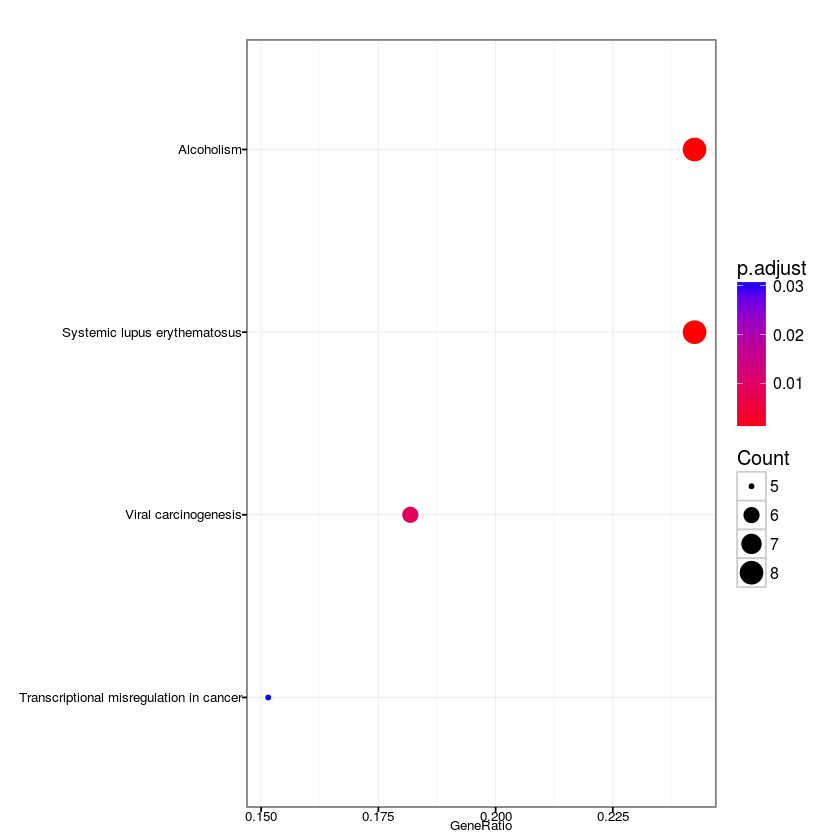

In [6]:
## An example of running KEGG pathway enrichment on the ovelapping genes
suppressMessages(library(clusterProfiler))

## Use the built-in bitr function to get the ENTREZIDs from the symbols
entrez.shared <- bitr(shared.dat$SYMBOL, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")

## Run KEGG enrichment
kegg.res <- enrichKEGG(gene=entrez.shared$ENTREZID,
                  org = 'hsa',
                  pAdjustMethod="BH",
                  qvalueCutoff=0.05)
dotplot(kegg.res, font.size=8)

### Viewing overlapping genes in IGV

Here is a snapshot of the [FOS](http://www.genecards.org/cgi-bin/carddisp.pl?gene=FOS) gene using the bigwig files for the ChIP-Seq and RNA-Seq samples in the [Integrative Genomics Viewer](http://software.broadinstitute.org/software/igv/). The first track contains the Ab1 peaks and the second track contains the RNAPII peaks. The next two tracks are the normalized bigwig Ab1 (dark blue) and RNAPII (light blue) ChIP-Seq files followed by the two control files (gray). The last six tracks show the RNA-Seq data from the knock-out samples (red) and the wild-type samples (green). Here we can clearly see that there is a "peak" in the ChIP-Seq data right around the TSS of the gene and there are relatively more reads aligned for the knock-out sample compared to the wild-type.

<img src="assets/f09_FOS_integration_IGV.png" alt="Figure 09" style="float: center;"/>

### More advanced integration

If you would like to perform a more advanced integration, I suggest you look into the [BETA](http://cistrome.org/BETA/) software from Cistrome.

> Wang, S., Sun, H., Ma, J., Zang, C., Wang, C., Wang, J., ... & Liu, X. S. (2013). Target analysis by integration of transcriptome and ChIP-seq data with BETA. Nature protocols, 8(12), 2502-2515. 

They provide both stand-alone and Galaxy-based access to BETA. Here is a brief description of BETA:

> Binding and Expression Target Analysis (BETA) is a software package that integrates ChIP-seq of transcription factors or chromatin regulators with differential gene expression data to infer direct target genes. BETA has three functions: (1) to predict whether the factor has activating or repressive function; (2) to infer the factor’s target genes; and (3) to identify the motif of the factor and its collaborators which might modulate the factor’s activating or repressive function. Here we describe the implementation and features of BETA to demonstrate its application to several datasets. BETA requires ~2GB RAM and 1h for the whole procedure.

# Other useful tools

* If you have replicates and multiple conditions for your ChIP-Seq data, the R/Bioconductor package [DiffBind](https://bioconductor.org/packages/release/bioc/html/DiffBind.html) provides several statistical methods for examining differential binding
* [Homer](http://homer.salk.edu/homer/) is a popular suite of ChIP-Seq tools
* The [Regulatory Genomics Toolbox](http://www.regulatory-genomics.org/) provides several python tools for ChIP-Seq analyses
* [OmicTools](https://omictools.com/chip-seq-category) has a nice aggregation of various ChIP-Seq tools and databases